In [1]:
cd Users/tuannaorhaner/Desktop

[Errno 2] No such file or directory: 'Users/tuannaorhaner/Desktop'
/Users/tuannaorhaner/Desktop


In [2]:
import pandas as pd

In [76]:
data_a = pd.read_csv('assignment4.1a.csv', parse_dates=['Date'])
data_b = pd.read_csv('assignment4.1b.csv')
data_c = pd.read_csv('assignment4.1c.csv')
data_p = pd.read_csv('PromotionDates.csv')

In [77]:
data_a['Date'] = pd.to_datetime(data_a['Date'])
data_a

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0
...,...,...,...,...
1873613,2015-07-30,292,315,0
1873614,2015-07-31,12,315,1
1873615,2015-07-31,104,315,1
1873616,2015-07-31,261,315,1


In [78]:

for index, row in data_p.iterrows():
    start_date = row['StartDate']
    end_date = row['EndDate']

    if '/' in start_date:
        parts = start_date.split('/')
        if len(parts) == 3:
            if int(parts[0]) > 12:
                data_p.at[index, 'StartDate'] = pd.to_datetime(start_date, format='%d/%m/%Y')
            else:
                try:
                    data_p.at[index, 'StartDate'] = pd.to_datetime(start_date, format='%m/%d/%Y')
                except ValueError:
                    data_p.at[index, 'StartDate'] = pd.to_datetime(start_date, format='%d/%m/%Y')
    
    if '/' in end_date:
        parts = end_date.split('/')
        if len(parts) == 3:
            if int(parts[0]) > 12:
                data_p.at[index, 'EndDate'] = pd.to_datetime(end_date, format='%d/%m/%Y')
            else:
                try:
                    data_p.at[index, 'EndDate'] = pd.to_datetime(end_date, format='%m/%d/%Y')
                except ValueError:
                    data_p.at[index, 'EndDate'] = pd.to_datetime(end_date, format='%d/%m/%Y')


mask = data_p['Period'] == 'Promo5'
for col in ['StartDate', 'EndDate']:
    data_p.loc[mask, col] = data_p.loc[mask, col].apply(
        lambda ts: ts.replace(month=ts.day, day=ts.month)
    )

In [79]:
data_p['StartDate'] = pd.to_datetime(data_p['StartDate'])
data_p['EndDate'] = pd.to_datetime(data_p['EndDate'])

In [80]:
data_a['IsPromotion'] = False
for _, row in data_p.iterrows():
    mask = (data_a['Date'] >= row['StartDate']) & (data_a['Date'] <= row['EndDate'])
    data_a.loc[mask, 'IsPromotion'] = True


In [81]:
non_promo = data_a[data_a['IsPromotion'] == False].copy()
non_promo['Week'] = non_promo['Date'].dt.isocalendar().week
non_promo['Year'] = non_promo['Date'].dt.isocalendar().year

In [12]:
# 1. ProductCode
product_weekly_sales = non_promo.groupby(['ProductCode', 'Year', 'Week'])['SalesQuantity'].sum().reset_index()
product_avg_weekly = product_weekly_sales.groupby('ProductCode')['SalesQuantity'].mean().reset_index()
product_avg_weekly.rename(columns={'SalesQuantity': 'AvgWeeklySales'}, inplace=True)
product_weekly_sales


,ProductCode,Year,Week,SalesQuantity
0,1,2015,1,203
1,1,2015,2,145
2,1,2015,24,186
3,1,2015,25,315
4,1,2015,27,294
...,...,...,...,...
2528,317,2015,27,11
2529,317,2015,28,16
2530,317,2015,29,14
2531,317,2015,30,14


In [13]:
# 2. StoreCode
store_weekly_sales = non_promo.groupby(['StoreCode', 'Year', 'Week'])['SalesQuantity'].sum().reset_index()
store_avg_weekly = store_weekly_sales.groupby('StoreCode')['SalesQuantity'].mean().reset_index()
store_avg_weekly.rename(columns={'SalesQuantity': 'AvgWeeklySales'}, inplace=True)
store_avg_weekly

,StoreCode,AvgWeeklySales
0,1,255.777778
1,2,935.333333
2,3,177.888889
3,4,294.555556
4,5,267.777778
...,...,...
332,336,229.444444
333,337,315.111111
334,338,291.444444
335,339,378.111111


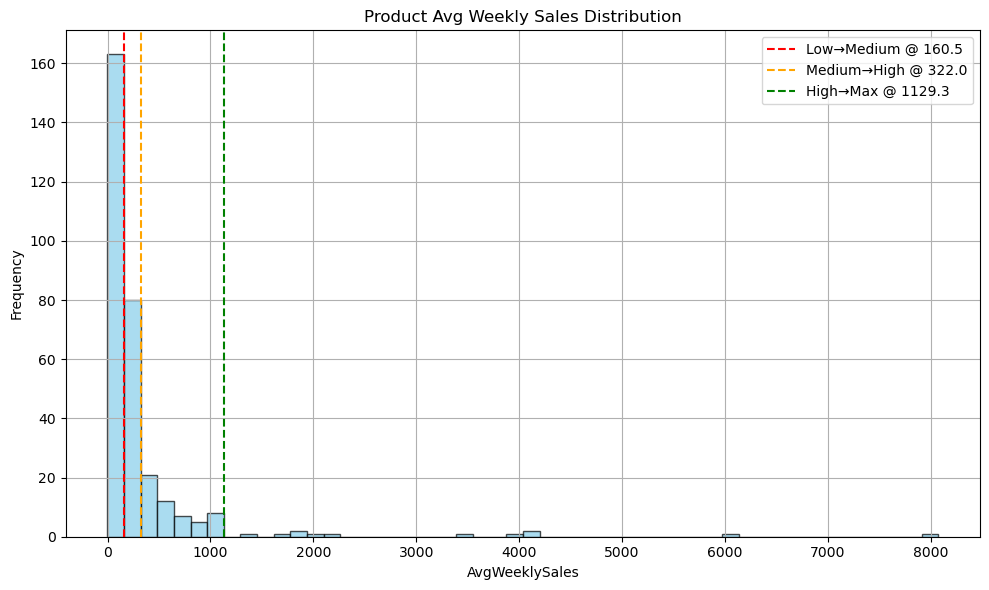

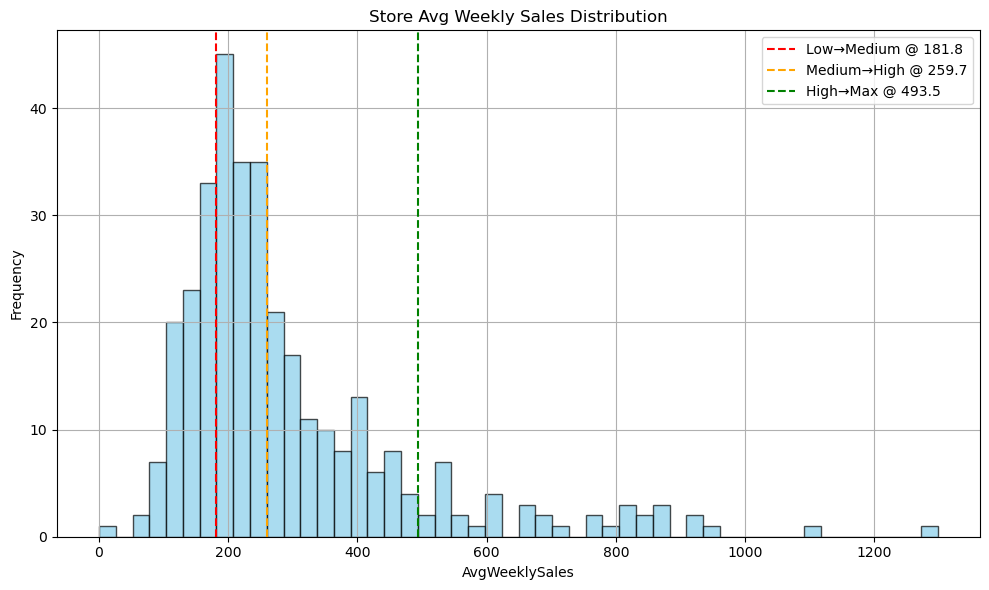

Product thresholds → Low/Med/High : 160.47777777777776 321.9555555555555 1129.3444444444444
Store   thresholds → Low/Med/High: 181.7977777777778 259.7111111111111 493.4511111111112


In [14]:
import numpy as np
import matplotlib.pyplot as plt

def cutoffs(values, bins=50, med_frac=0.5, high_frac=0.05):
    counts, bin_edges = np.histogram(values, bins=bins)
    pdf = counts / counts.sum()
    cdf = np.cumsum(pdf)

    grad = np.diff(cdf)
    max_idx = np.argmax(grad)
    max_grad = grad[max_idx]
 
    after_max = grad[max_idx+1:]
    med_rel = np.where(after_max < max_grad * med_frac)[0]
    med_idx = med_rel[0] + max_idx + 1 if med_rel.size > 0 else max_idx + 1
    
    after_med = grad[med_idx+1:]
    high_rel = np.where(after_med < max_grad * high_frac)[0]
    high_idx = high_rel[0] + med_idx + 1 if high_rel.size > 0 else len(grad)-1
    
    low_to = bin_edges[max_idx+1]
    med_to = bin_edges[med_idx+1]
    high_to = bin_edges[high_idx+1]
    
    return low_to, med_to, high_to

def plot_with_cutoffs(data, column, title):
    plt.figure(figsize=(10, 6))
    vals = data[column].dropna().values
    plt.hist(vals, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    
    low_end, med_end, high_end = cutoffs(vals, bins=50)
    
    plt.axvline(low_end, color='red', linestyle='--', label=f'Low→Medium @ {low_end:.1f}')
    plt.axvline(med_end, color='orange', linestyle='--', label=f'Medium→High @ {med_end:.1f}')
    plt.axvline(high_end, color='green', linestyle='--', label=f'High→Max @ {high_end:.1f}')
    
    plt.title(title)
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return low_end, med_end, high_end

low_p, med_p, high_p = plot_with_cutoffs(product_avg_weekly, 'AvgWeeklySales', 'Product Avg Weekly Sales Distribution')
low_s, med_s, high_s = plot_with_cutoffs(store_avg_weekly,   'AvgWeeklySales', 'Store Avg Weekly Sales Distribution')

print("Product thresholds → Low/Med/High :", low_p, med_p, high_p)
print("Store   thresholds → Low/Med/High:", low_s, med_s, high_s)


In [15]:
import statsmodels.formula.api as smf

#cluster labels for products
def assign_cluster(x, low, med, high):
    if x <= low:
        return 'Low'
    elif x <= med:
        return 'Medium'
    elif x <= high:
        return 'High'
    else:
        return 'Max'

product_avg_weekly['ProductCluster'] = product_avg_weekly['AvgWeeklySales'].apply(
    lambda x: assign_cluster(x, low_p, med_p, high_p))

store_avg_weekly['StoreCluster'] = store_avg_weekly['AvgWeeklySales'].apply(
    lambda x: assign_cluster(x, low_s, med_s, high_s))


data_effect = (
    data_a
    .merge(product_avg_weekly[['ProductCode', 'AvgWeeklySales', 'ProductCluster']],
           on='ProductCode', how='left')
    .merge(store_avg_weekly[['StoreCode', 'AvgWeeklySales', 'StoreCluster']],
           on='StoreCode', how='left')
)

In [16]:
# 3)  Simple regression: promo effect by product clusters
model_prod = smf.ols(
    'SalesQuantity ~ IsPromotion * C(ProductCluster)',
    data=data_effect
).fit()
print(model_prod.summary())


                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                 3.262e+04
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:19:32   Log-Likelihood:            -5.5771e+06
No. Observations:             1873603   AIC:                         1.115e+07
Df Residuals:                 1873595   BIC:                         1.115e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [17]:
# 4) promo effect by store clusters
model_store = smf.ols(
    'SalesQuantity ~ IsPromotion * C(StoreCluster)',
    data=data_effect
).fit()
print(model_store.summary())


                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2082.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:19:37   Log-Likelihood:            -5.6775e+06
No. Observations:             1873572   AIC:                         1.135e+07
Df Residuals:                 1873564   BIC:                         1.136e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [18]:
# 5)Product+Store Clusters Together
model_both = smf.ols(
    'SalesQuantity ~ IsPromotion * C(ProductCluster) + IsPromotion * C(StoreCluster)',
    data=data_effect
).fit()
print(model_both.summary())

                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                 1.895e+04
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        02:19:49   Log-Likelihood:            -5.5690e+06
No. Observations:             1873557   AIC:                         1.114e+07
Df Residuals:                 1873543   BIC:                         1.114e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [19]:
model_both = smf.ols(
    'SalesQuantity ~ IsPromotion * C(ProductCluster) + IsPromotion * C(StoreCluster)',
    data=data_effect
).fit()


In [50]:
data_b['Date'] = pd.to_datetime(data_b['Date'])

In [ ]:
promo5 = data_p.loc[data_p['Period']=='Promo5'].iloc[0]
promo5_start, promo5_end = promo5['StartDate'], promo5['EndDate']

promo5_b = data_b[(data_b['Date'] >= promo5_start) & (data_b['Date'] <= promo5_end)].copy()


In [52]:
promo5_b = promo5_b.merge(product_avg_weekly[['ProductCode', 'AvgWeeklySales', 'ProductCluster']],
                          on='ProductCode', how='left')
promo5_b = promo5_b.merge(store_avg_weekly[['StoreCode', 'AvgWeeklySales', 'StoreCluster']],
                          on='StoreCode', how='left')

promo5_b['IsPromotion'] = True


In [ ]:

promo5_b['Predicted'] = model_both.predict(promo5_b)

promo5_b['Residual'] = promo5_b['SalesQuantity'] - promo5_b['Predicted']

print("Comparison of Predicted vs Actual Sales for Promotion 5:")
print(promo5_b[['StoreCode', 'ProductCode', 'SalesQuantity', 'Predicted', 'Residual']])


Comparison of Predicted vs Actual Sales for Promotion 5:
       StoreCode  ProductCode  SalesQuantity  Predicted  Residual
0              1           25              1   1.083230 -0.083230
1              1           37              1   0.558311  0.441689
2              1           38              1   0.558311  0.441689
3              1           46              1   1.083230 -0.083230
4              1           71              2   1.083230  0.916770
...          ...          ...            ...        ...       ...
41470        340          224              1   1.411507 -0.411507
41471        340          232              1   2.327730 -1.327730
41472        340          288              2   2.327730 -0.327730
41473        340          305              1   1.411507 -0.411507
41474        340          313              2   2.327730 -0.327730

[41475 rows x 5 columns]


In [82]:
def calculate_metrics(actual, predicted):
    mae = np.mean(np.abs(actual - predicted))  
    mse = np.mean((actual - predicted) ** 2)  
    rmse = np.sqrt(mse)  
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

metrics_promo5 = calculate_metrics(promo5_b['SalesQuantity'], promo5_b['Predicted'])

print("\nGoodness of Fit Metrics for Promotion 5:")
for k, v in metrics_promo5.items():
    print(f"{k}: {v:.4f}")


Goodness of Fit Metrics for Promotion 5:
MAE: 2.5465
MSE: 31.5101
RMSE: 5.6134


In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
#holt winters
weekly_ts = data_b['SalesQuantity'].resample('W').mean()

hw = ExponentialSmoothing(
    weekly_ts,
    trend='mul',
    seasonal='mul',
    seasonal_periods=4  
).fit()

fitted = hw.fittedvalues
forecast = hw.forecast(steps=8)
print(hw.params)

{'smoothing_level': 1.4901161193847656e-08, 'smoothing_trend': 1.4876633913107501e-08, 'smoothing_seasonal': 4.327534288743558e-17, 'damping_trend': nan, 'initial_level': 2.2414700451789553, 'initial_trend': 0.9928846222675314, 'initial_seasons': array([0.98639902, 1.05750226, 0.98051919, 0.97242785]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


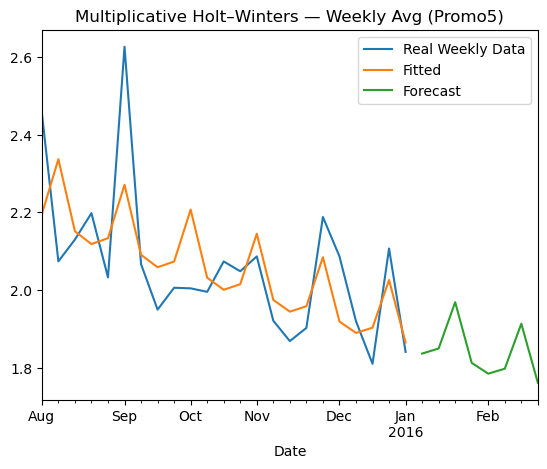

In [83]:

plt.figure()
weekly_ts.plot(label='Real Weekly Data', legend=True)
fitted.plot(label='Fitted', legend=True)
forecast.plot(label='Forecast', legend=True)
plt.title('Multiplicative Holt–Winters — Weekly Avg (Promo5)')
plt.show()

In [84]:

def calculate_metrics(actual, predicted):
    mae  = np.mean(np.abs(actual - predicted))       
    mse  = np.mean((actual - predicted) ** 2)         
    rmse = np.sqrt(mse)                                 
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100 
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse}


metrics_weekly = calculate_metrics(weekly_ts, fitted)

print("\nGoodness of Fit Metrics for Weekly‐Aggregated Promo5:")
for name, val in metrics_weekly.items():
    print(f"{name}: {val:.4f}")


Goodness of Fit Metrics for Weekly‐Aggregated Promo5:
MAE: 0.1031
MSE: 0.0181
RMSE: 0.1347
